Boundary Value Problem
======================

In [12]:
import torch
import os
import pytorch_lightning as pl
import torchphysics as tp

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use
torch.cuda.is_available()

True

In [13]:
# First define all parameters:
L = 1 # length of domain
u_m = 3.5 #m/s
beta = 2.2e-08 # m^2/N
nu0 = 1e-03
nu1 = 1e-1

In [14]:
X = tp.spaces.R1('x')
NU = tp.spaces.R1('nu')
P = tp.spaces.R1('p')


space_domain = tp.domains.Interval(X, 0, L)
nu_domain = tp.domains.Interval(NU, nu0, nu1)

In [15]:
# define the function for the viscosity.
def nu_func(nu,p):
    out = nu * torch.exp(beta * p)
    return out

In [16]:
model = tp.models.FCN(input_space=X*NU, output_space=P, hidden=(50, 50, 50, 50, 50))
normalize_layer = tp.models.NormalizationLayer(space_domain*nu_domain)
seq_model = tp.models.Sequential(normalize_layer, model)

In [17]:
def boundary_fn(p):
    return p - 1

bound_sampler = tp.samplers.RandomUniformSampler(space_domain.boundary*nu_domain, n_points=3500)

bound_cond = tp.conditions.PINNCondition(module=seq_model, 
                                         sampler=bound_sampler, 
                                         residual_fn=boundary_fn, 
                                         weight=500.0)

In [18]:
def pde(nu, p, x):
    nu = nu_func(nu, p) # evaluate the viscosity
    p_x  = tp.utils.grad(p, x)
    p_xx = tp.utils.grad(p_x, x)
    out = - nu*p_xx + p_x + p - 2
    return out

inner_sampler = tp.samplers.ExponentialIntervalSampler(space_domain, n_points=150, exponent=0.5)   
inner_sampler = inner_sampler.make_static()
nu_sampler = tp.samplers.RandomUniformSampler(nu_domain, n_points=50)
pde_sampler = inner_sampler * nu_sampler

pde_cond = tp.conditions.PINNCondition(module=seq_model,
                                       sampler=pde_sampler, 
                                       residual_fn=pde)

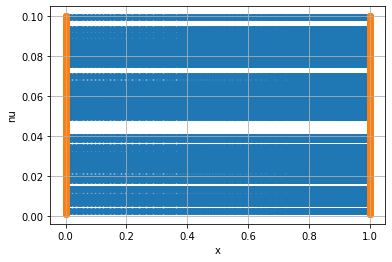

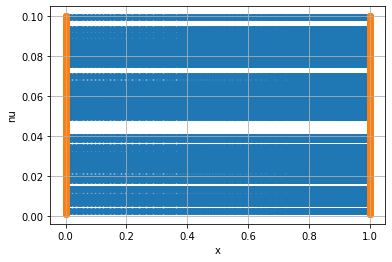

In [19]:
tp.utils.scatter(X*NU, pde_sampler, bound_sampler)

In [20]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0001)

solver = tp.solver.Solver([pde_cond, bound_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=20000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.4 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [21]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 10, 'history_size': 100})

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1,
                     max_steps=8000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.4 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

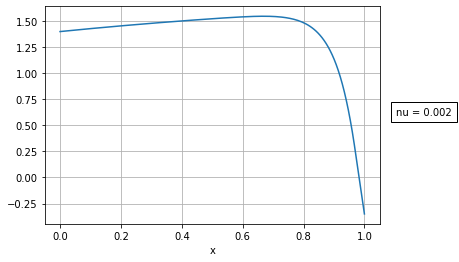

In [22]:
nu = 0.002
if nu0 <= nu and nu <= nu1:
    plot_sampler = tp.samplers.PlotSampler(plot_domain=space_domain, n_points=150, device='cuda',
                                           data_for_other_variables={'nu': nu})
    fig = tp.utils.plot(model, lambda p : p, plot_sampler)
else:
    print('Not inside trainings range')